In [1]:
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from datasets.custom_datasets import LSPDataset, MPIIDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from models.pose_estimation_model import TransformerPoseModel
from utils.training_helpers import resize_single_joint
# from utils.training_helpers import plot_with_joints
from utils.training_helpers import plot_with_joints_r
from utils.preprocessing_helpers import get_image_sizes
from models.loss import JointsMSELoss
from torch.optim import Adam
from utils.heatmap_funcs import generate_gaussian_heatmap, generate_single_image_gaussian, upsample_heatmap
import torchvision.io

In [2]:
# dataset loading
#swap axis -> (n,#joints,cooridantes)
# annot = np.load('/home/mxerri/JointPoseEstimation/Data/lsp/leeds_sports_extended.npy')
annot = np.load('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/leeds_sports_extended.npy')
annot_s = np.swapaxes(annot, 0,2)
annot_s = np.swapaxes(annot_s,1,2)

# retrieve image sizes
# image_sizes = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images/')
image_sizes = get_image_sizes('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images/')
# image_sizes_resized = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images224/')
image_sizes_resized = get_image_sizes('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/')
annot_resize = np.zeros_like(annot_s)

# resize annotations
for i in range(10000):
    annot_resize[i] = resize_single_joint(annot_s[i],image_sizes_resized[i],image_sizes[i] ) 
    # make annortations into 56 x 56 for loss function 
    annot_resize[i] = resize_single_joint(annot_resize[i],(56,56),(224,224))

print(annot_resize.shape)

# heatmap annotations are converted in the dataloader, otherwise we can change pagetable size 
# to accomodate a larger array to pre-load 

# create officia datasets and dataloaders for training
dataset = LSPDataset(annot_resize,"/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/")
dataset_mini = torch.utils.data.Subset(dataset,list(range(0,20)))
train_loader = DataLoader(dataset, batch_size=16, shuffle=False) # changed 32 -> 16
train_loader_mini = DataLoader(dataset_mini, batch_size=16, shuffle=False) # changed 5 -> 16

(10000, 14, 3)


(10, 14, 56, 56)
(56, 56)
(18, 40)
[18. 40.  1.]


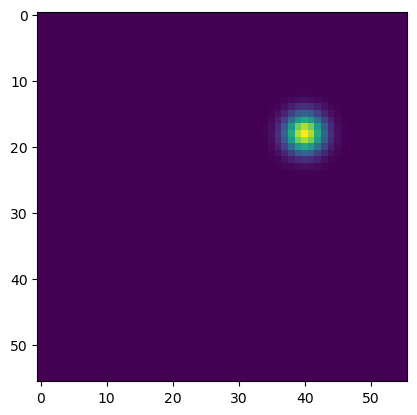

In [3]:
# convert to joint heatmaps from coordiantes: 
heatmaps = generate_gaussian_heatmap(annot_resize[0:10],(56,56),2)
print(heatmaps.shape)
# heatmaps_down = upsample_heatmap(heatmaps, (56,56))
plt.imshow(heatmaps[0][2])
print(heatmaps[0][2].shape)
z = np.unravel_index(heatmaps[0,2,:,:].argmax(), heatmaps[0,2,:,:].shape)
print(z)
print(annot_resize[0,2,:])



In [4]:
model = TransformerPoseModel(2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = JointsMSELoss()

/opt/miniconda3/envs/jpe/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


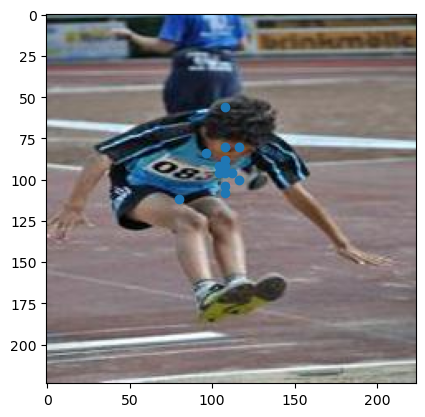

[tensor(80), tensor(104), tensor(104), tensor(108), tensor(116), tensor(108), tensor(108), tensor(96), tensor(112), tensor(116), tensor(108), tensor(108), tensor(108), tensor(108)]
[tensor(112), tensor(92), tensor(96), tensor(88), tensor(100), tensor(104), tensor(108), tensor(84), tensor(96), tensor(80), tensor(92), tensor(96), tensor(80), tensor(56)]


In [14]:
def test_plot():
  im = torchvision.io.read_image('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/resized_im00004.jpg')
  im = torch.unsqueeze(im, 0)

  joints = model(im, False)
  joints = joints.squeeze()
  im = im.squeeze()
  x = []
  y = []
  for joint in joints:
    # print(f"max: {(joint==torch.max(joint)).nonzero()}")
    coor = (joint==torch.max(joint)).nonzero()
    x.append(coor[0][0] * 4)
    y.append(coor[0][1] * 4)
  plot_with_joints_r(im, x, y)
  print(x)
  print(y)
test_plot()

In [6]:
def displayHeatmap(heatmap):
  print('show image!!')
  plt.imshow(heatmap[0][0].detach().numpy())
  plt.show()

625
5%
Heatmap At 10%
show image!!


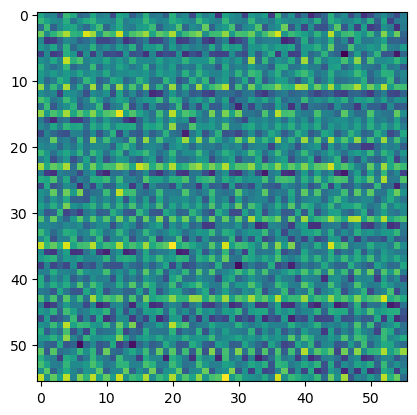

10%
15%
Heatmap At 20%
show image!!


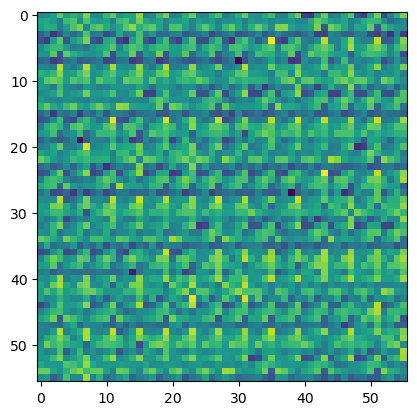

20%
25%
Heatmap At 30%
show image!!


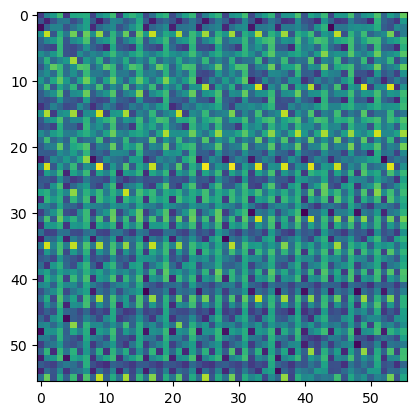

30%
35%
Heatmap At 40%
show image!!


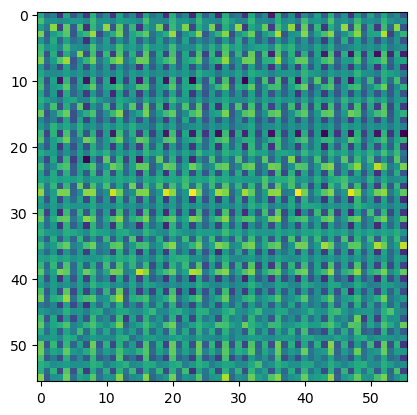

40%
45%
Heatmap At 50%
show image!!


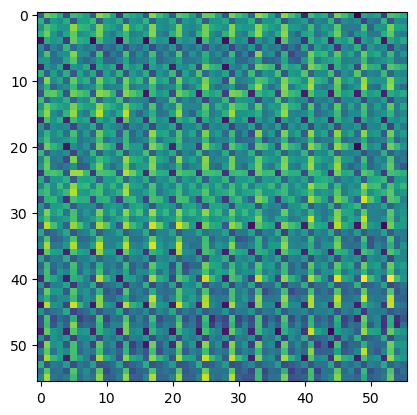

50%
55%
Heatmap At 60%
show image!!


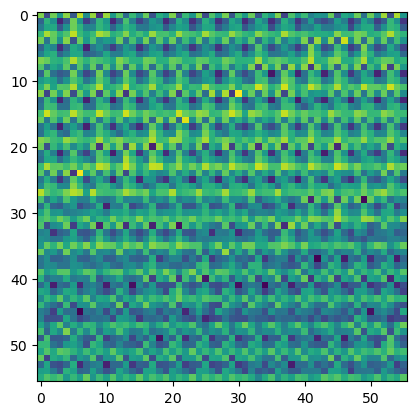

60%
65%
Heatmap At 70%
show image!!


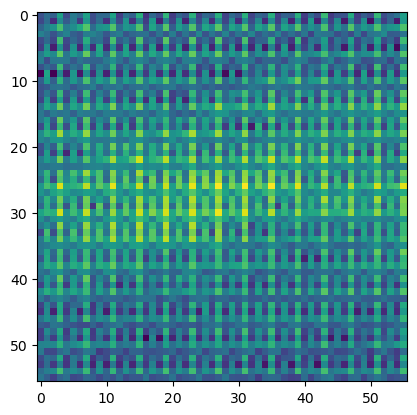

70%
75%
Heatmap At 80%
show image!!


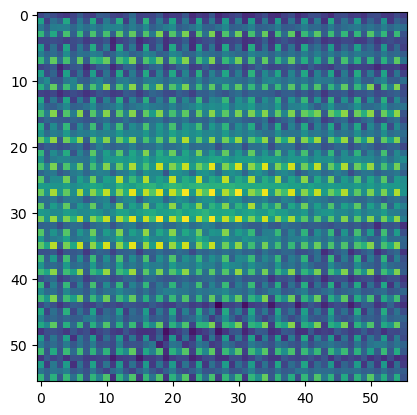

80%
85%
Heatmap At 90%
show image!!


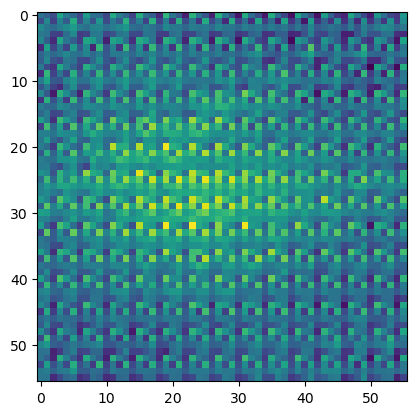

90%
95%
Heatmap At 100%
show image!!


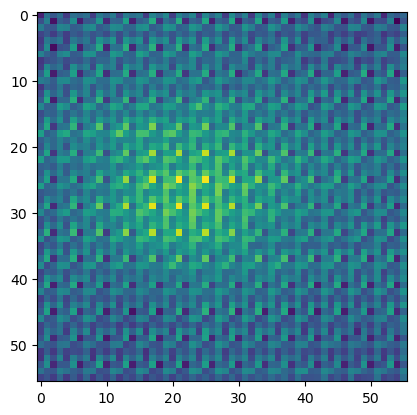

100%
epoch:  0 loss:  tensor(3.1375, grad_fn=<AddBackward0>)


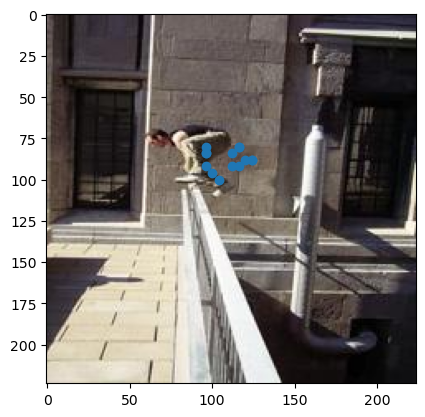

[tensor(96), tensor(96), tensor(96), tensor(100), tensor(124), tensor(116), tensor(120), tensor(104), tensor(124), tensor(112), tensor(112), tensor(116), tensor(96), tensor(116)]
[tensor(80), tensor(84), tensor(92), tensor(96), tensor(88), tensor(80), tensor(88), tensor(100), tensor(88), tensor(92), tensor(84), tensor(92), tensor(84), tensor(80)]
625
5%
Heatmap At 10%
show image!!


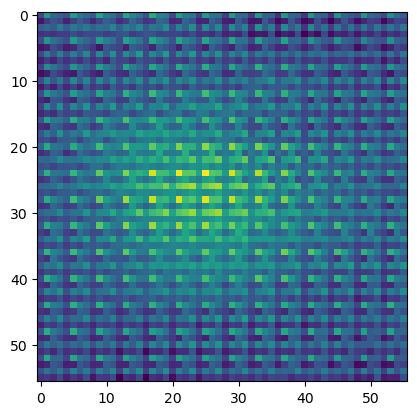

10%
15%
Heatmap At 20%
show image!!


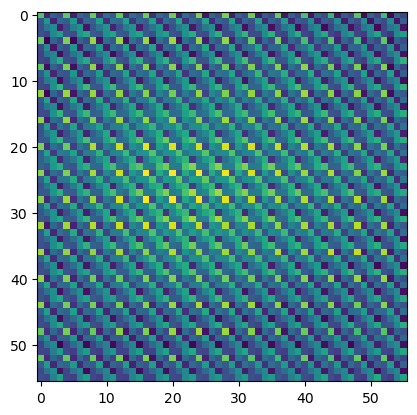

20%
25%
Heatmap At 30%
show image!!


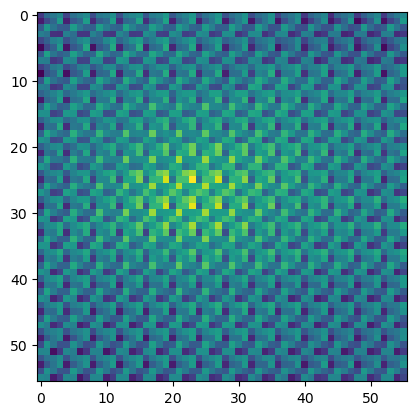

30%
35%
Heatmap At 40%
show image!!


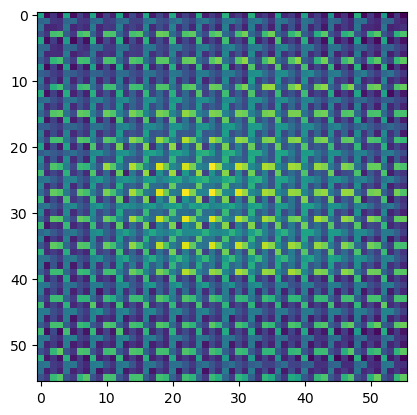

40%
45%
Heatmap At 50%
show image!!


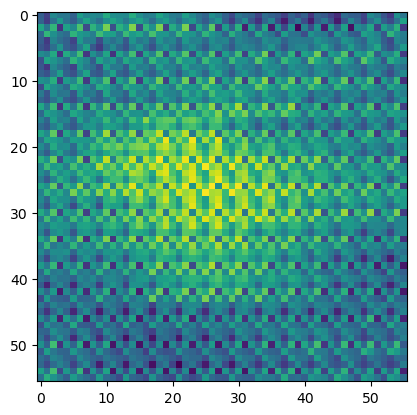

50%
55%
Heatmap At 60%
show image!!


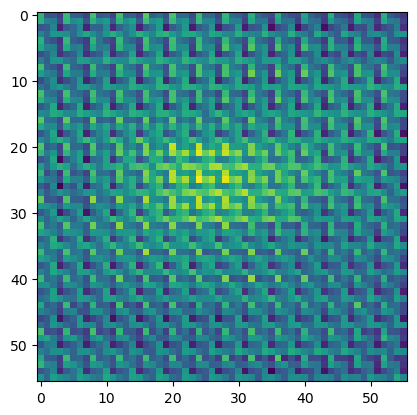

60%
65%
Heatmap At 70%
show image!!


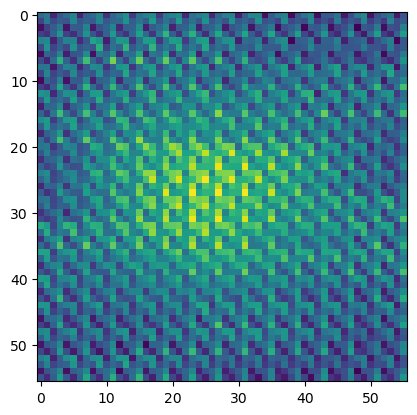

70%
75%
Heatmap At 80%
show image!!


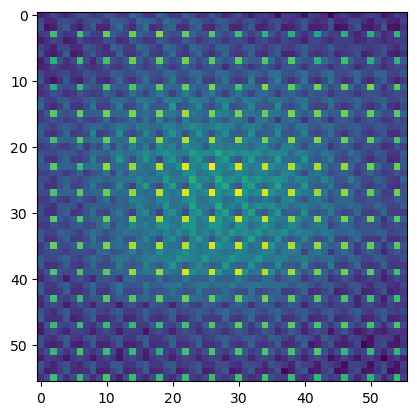

80%
85%
Heatmap At 90%
show image!!


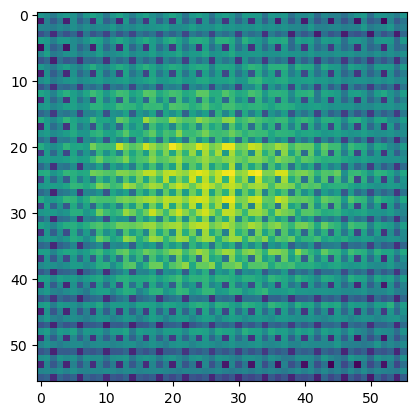

90%
95%
Heatmap At 100%
show image!!


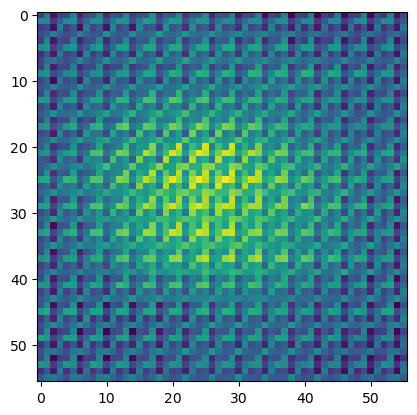

100%
epoch:  1 loss:  tensor(2.5076, grad_fn=<AddBackward0>)


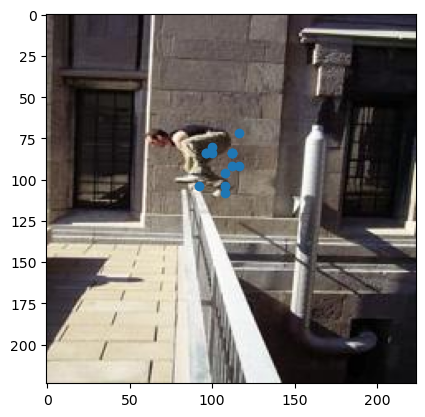

[tensor(92), tensor(100), tensor(108), tensor(112), tensor(108), tensor(108), tensor(96), tensor(96), tensor(100), tensor(112), tensor(112), tensor(116), tensor(112), tensor(116)]
[tensor(104), tensor(80), tensor(96), tensor(92), tensor(104), tensor(108), tensor(84), tensor(84), tensor(84), tensor(84), tensor(84), tensor(92), tensor(84), tensor(72)]
625


KeyboardInterrupt: 

In [7]:
for epoch in range(5):
    total_loss = 0
    count = 0
    print(len(train_loader))
    for batch_idx, (imgs, labels) in enumerate(train_loader):

        #print(batch_idx)
        #print(imgs.shape)
        #print(labels.shape)

        optimizer.zero_grad()

        output = model(imgs, True) # -> (5, H/4, W/4, #joints) 

        # Heatmap dimensions are 56x56, so we need to resize at the end

        #print("model output shape")
        #print(output.shape)

        # upsample heatmap to 224 
        #output = upsample_heatmap(output, (224,224)) # check this doesnt mess w back prop

        if batch_idx % 62 == 0 and batch_idx != 0:
            print(f"Heatmap At {int(batch_idx / len(train_loader) * 100) + 1}%")
            displayHeatmap(output)

        loss = loss_func(output, labels.float())
        
        loss.backward()
        optimizer.step()
        total_loss += loss

        # print("batch completed")
        if batch_idx % 31 == 0 and batch_idx > 0:
            print(f"{int(batch_idx / len(train_loader) * 100) + 1}%")
    if epoch % 1 == 0:
        print("epoch: ", epoch, "loss: ", total_loss)
        test_plot()